# EDA Step 4: 변수 간 관계 탐색

**목적**: 중요한 변수와 패턴을 식별
- 수치 ↔ 수치: scatter, correlation
- 수치 ↔ 범주: boxplot, 그룹별 평균
- 범주 ↔ 범주: crosstab

**핵심 질문**:
1. 어떤 User 특성이 Rating에 영향을 주는가?
2. 어떤 Item 특성이 Rating에 영향을 주는가?
3. User Activity/Item Popularity와 Rating의 관계는?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
books = pd.read_csv('../data/books.csv')
users = pd.read_csv('../data/users.csv')
train = pd.read_csv('../data/train_ratings.csv')
test = pd.read_csv('../data/test_ratings.csv')

In [2]:
# 데이터 전처리: 분석을 위한 파생 변수 생성

# 1. User별 통계
user_stats = train.groupby('user_id').agg(
    user_rating_count=('rating', 'count'),
    user_rating_mean=('rating', 'mean'),
    user_rating_std=('rating', 'std')
).reset_index()

# 2. Item별 통계
item_stats = train.groupby('isbn').agg(
    item_rating_count=('rating', 'count'),
    item_rating_mean=('rating', 'mean'),
    item_rating_std=('rating', 'std')
).reset_index()

# 3. Books 전처리
def extract_first_category(cat_str):
    if pd.isna(cat_str):
        return None
    try:
        cat_list = ast.literal_eval(cat_str)
        if isinstance(cat_list, list) and len(cat_list) > 0:
            return cat_list[0]
    except:
        pass
    return cat_str

books['category_main'] = books['category'].apply(extract_first_category)

# 4. Users 전처리
users['country'] = users['location'].str.split(', ').str[-1].str.strip().str.lower()

# 5. Train에 메타데이터 병합
train_merged = train.merge(users, on='user_id', how='left')
train_merged = train_merged.merge(books, on='isbn', how='left')
train_merged = train_merged.merge(user_stats, on='user_id', how='left')
train_merged = train_merged.merge(item_stats, on='isbn', how='left')

print(f"병합된 Train 데이터: {train_merged.shape}")
print(f"컬럼: {list(train_merged.columns)}")

병합된 Train 데이터: (306795, 22)
컬럼: ['user_id', 'isbn', 'rating', 'location', 'age', 'country', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_url', 'language', 'category', 'summary', 'img_path', 'category_main', 'user_rating_count', 'user_rating_mean', 'user_rating_std', 'item_rating_count', 'item_rating_mean', 'item_rating_std']


---
## 4.1 Rating vs User Age

[Age 구간별 Rating 통계]
           rating_mean  rating_std  rating_count
age_group                                       
~20              7.099       2.507         12724
20-30            7.244       2.363         55549
30-40            7.089       2.437         66874
40-50            7.264       2.308         42891
50-60            7.429       2.267         27018
60+              7.245       2.382          9077


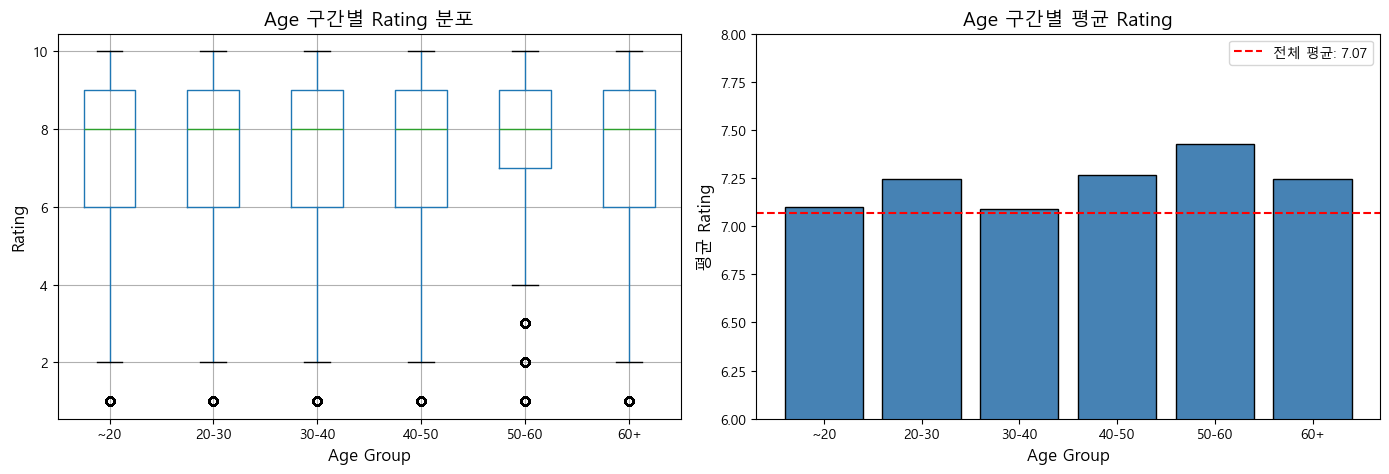

In [3]:
# Age 구간별 Rating 분석
age_bins = [0, 20, 30, 40, 50, 60, 100]
age_labels = ['~20', '20-30', '30-40', '40-50', '50-60', '60+']
train_merged['age_group'] = pd.cut(train_merged['age'], bins=age_bins, labels=age_labels, right=False)

age_rating = train_merged.groupby('age_group', observed=True).agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count')
).round(3)

print("[Age 구간별 Rating 통계]")
print(age_rating)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
ax1 = axes[0]
train_merged[train_merged['age'].notna()].boxplot(column='rating', by='age_group', ax=ax1)
ax1.set_xlabel('Age Group', fontsize=12)
ax1.set_ylabel('Rating', fontsize=12)
ax1.set_title('Age 구간별 Rating 분포', fontsize=14)
plt.suptitle('')

# 평균 Rating 바 차트
ax2 = axes[1]
ax2.bar(age_rating.index.astype(str), age_rating['rating_mean'], color='steelblue', edgecolor='black')
ax2.axhline(train['rating'].mean(), color='red', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax2.set_xlabel('Age Group', fontsize=12)
ax2.set_ylabel('평균 Rating', fontsize=12)
ax2.set_title('Age 구간별 평균 Rating', fontsize=14)
ax2.legend()
ax2.set_ylim(6, 8)

plt.tight_layout()
plt.show()

---
## 4.2 Rating vs User Country

[상위 10개 국가별 Rating 통계]
                rating_mean  rating_std  rating_count
country                                              
usa                   7.120       2.441        209702
canada                6.943       2.393         28406
united kingdom        7.167       2.338         11826
germany               6.802       2.649          9730
,                     6.927       2.500          5881
spain                 6.716       2.316          5774
australia             6.935       2.251          5603
n/a                   6.780       2.608          5531
france                7.084       2.282          3700
portugal              7.351       2.000          2763


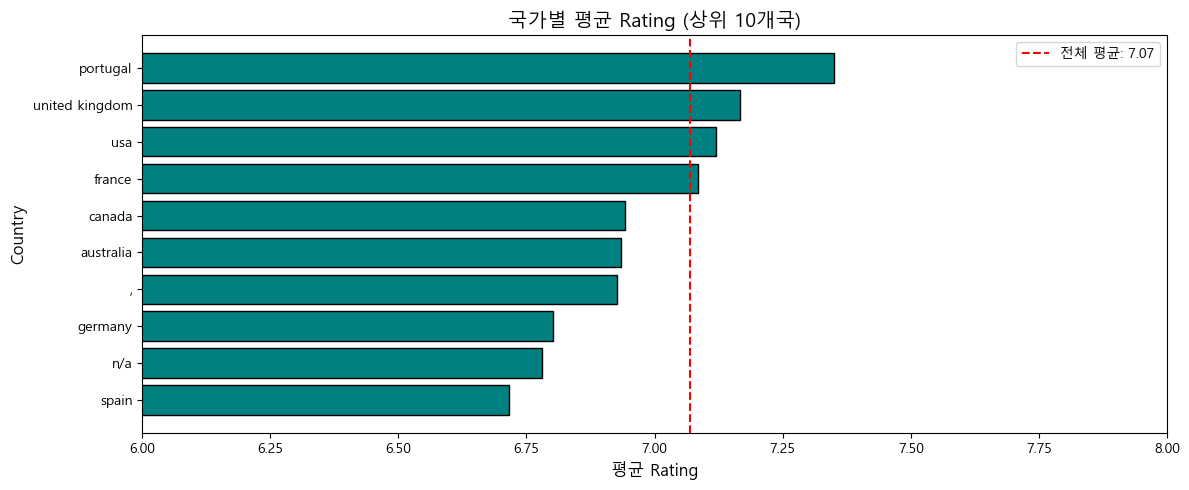

In [4]:
# 상위 10개 국가별 Rating 분석
top_countries = train_merged['country'].value_counts().head(10).index.tolist()
train_top_countries = train_merged[train_merged['country'].isin(top_countries)]

country_rating = train_top_countries.groupby('country').agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count')
).round(3).sort_values('rating_count', ascending=False)

print("[상위 10개 국가별 Rating 통계]")
print(country_rating)

# 시각화
fig, ax = plt.subplots(figsize=(12, 5))

country_sorted = country_rating.sort_values('rating_mean', ascending=True)
ax.barh(country_sorted.index, country_sorted['rating_mean'], color='teal', edgecolor='black')
ax.axvline(train['rating'].mean(), color='red', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax.set_xlabel('평균 Rating', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.set_title('국가별 평균 Rating (상위 10개국)', fontsize=14)
ax.legend()
ax.set_xlim(6, 8)

plt.tight_layout()
plt.show()

---
## 4.3 Rating vs Book Category

[상위 15개 카테고리별 Rating 통계]
                           rating_mean  rating_std  rating_count
category_main                                                   
Fiction                          6.979       2.413        108569
Juvenile Fiction                 7.521       2.381         12019
Biography & Autobiography        7.245       2.375          7648
Humor                            7.364       2.340          3132
History                          7.298       2.376          2672
Religion                         7.398       2.483          2402
Body, Mind & Spirit              7.207       2.569          1729
Juvenile Nonfiction              7.327       2.555          1659
Social Science                   7.048       2.407          1637
Family & Relationships           6.958       2.648          1514
Business & Economics             6.822       2.606          1505
Self-Help                        7.042       2.543          1394
Health & Fitness                 6.925       2.652          1285


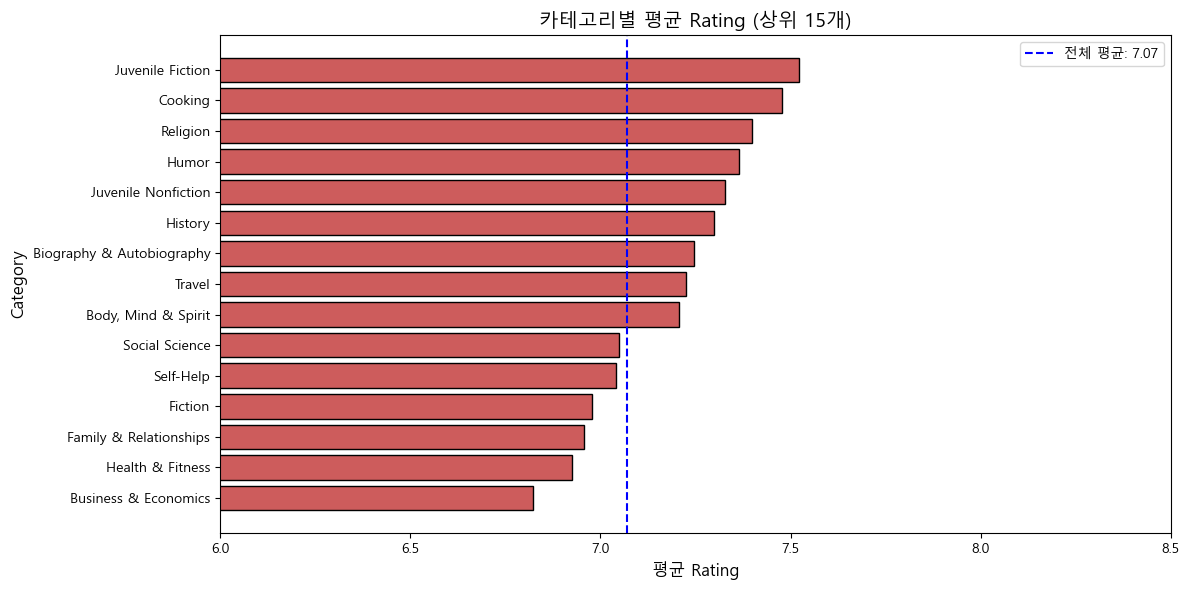

In [5]:
# 상위 15개 카테고리별 Rating 분석
top_categories = train_merged['category_main'].value_counts().head(15).index.tolist()
train_top_cats = train_merged[train_merged['category_main'].isin(top_categories)]

cat_rating = train_top_cats.groupby('category_main').agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count')
).round(3).sort_values('rating_count', ascending=False)

print("[상위 15개 카테고리별 Rating 통계]")
print(cat_rating)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

cat_sorted = cat_rating.sort_values('rating_mean', ascending=True)
ax.barh(cat_sorted.index, cat_sorted['rating_mean'], color='indianred', edgecolor='black')
ax.axvline(train['rating'].mean(), color='blue', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax.set_xlabel('평균 Rating', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_title('카테고리별 평균 Rating (상위 15개)', fontsize=14)
ax.legend()
ax.set_xlim(6, 8.5)

plt.tight_layout()
plt.show()

---
## 4.4 Rating vs Year of Publication

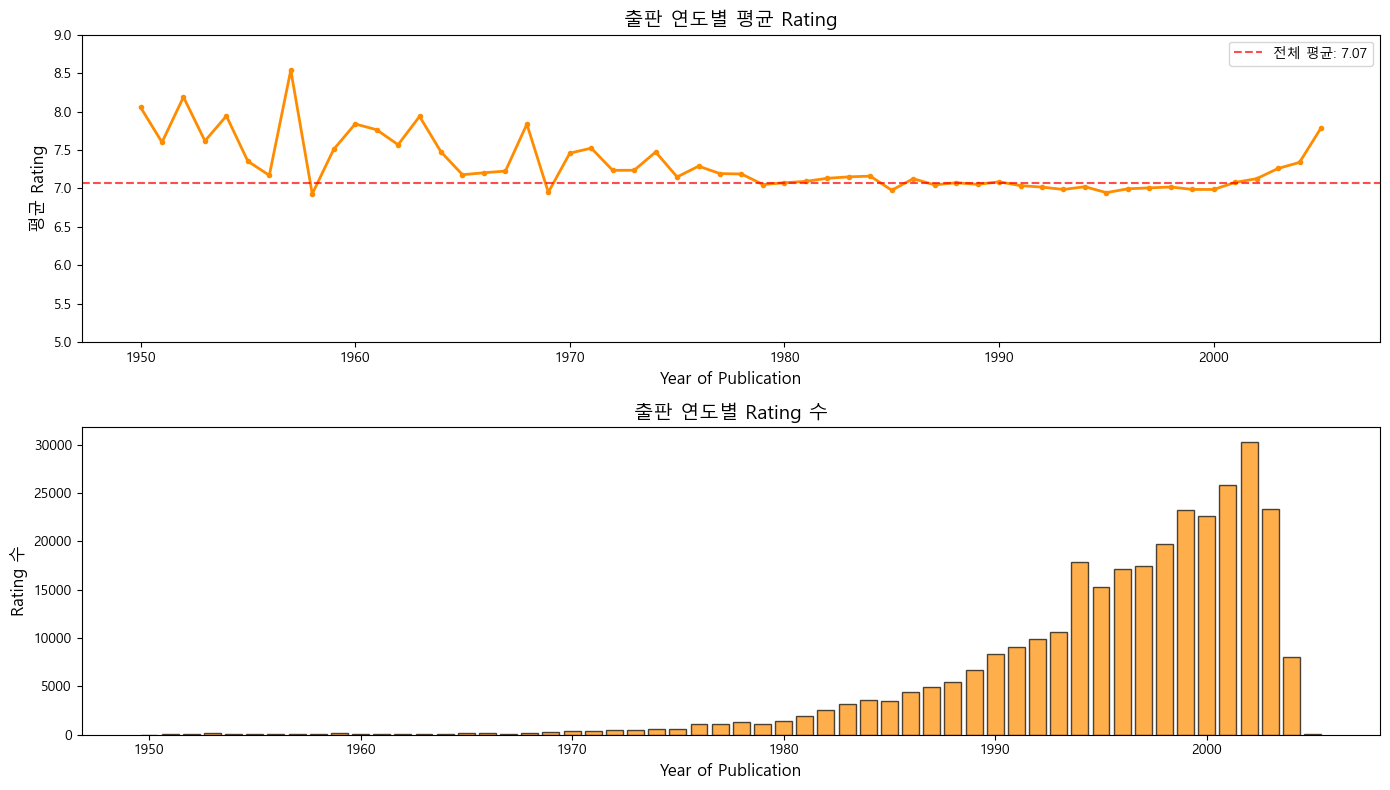


[연도 구간별 Rating 통계]
            rating_mean  rating_count
year_group                           
1950-1979         7.272         11199
1980-1989         7.084         44779
1990-1994         6.999         62742
1995-1999         6.998        100235
2000-2002         7.150         79455
2003-2006         7.341          8115


In [6]:
# 연도별 Rating 분석 (1950년 이후)
train_year = train_merged[(train_merged['year_of_publication'] >= 1950) & 
                          (train_merged['year_of_publication'] <= 2006)]

year_rating = train_year.groupby('year_of_publication').agg(
    rating_mean=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 연도별 평균 Rating
ax1 = axes[0]
ax1.plot(year_rating['year_of_publication'], year_rating['rating_mean'], 
         color='darkorange', linewidth=2, marker='o', markersize=3)
ax1.axhline(train['rating'].mean(), color='red', linestyle='--', alpha=0.7, label=f'전체 평균: {train["rating"].mean():.2f}')
ax1.set_xlabel('Year of Publication', fontsize=12)
ax1.set_ylabel('평균 Rating', fontsize=12)
ax1.set_title('출판 연도별 평균 Rating', fontsize=14)
ax1.legend()
ax1.set_ylim(5, 9)

# 연도별 Rating 수
ax2 = axes[1]
ax2.bar(year_rating['year_of_publication'], year_rating['rating_count'], 
        color='darkorange', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Year of Publication', fontsize=12)
ax2.set_ylabel('Rating 수', fontsize=12)
ax2.set_title('출판 연도별 Rating 수', fontsize=14)

plt.tight_layout()
plt.show()

# 연도 구간별 통계
print("\n[연도 구간별 Rating 통계]")
year_bins = [1950, 1980, 1990, 1995, 2000, 2003, 2006]
year_labels = ['1950-1979', '1980-1989', '1990-1994', '1995-1999', '2000-2002', '2003-2006']
train_year['year_group'] = pd.cut(train_year['year_of_publication'], bins=year_bins, labels=year_labels, right=True)

year_group_stats = train_year.groupby('year_group', observed=True).agg(
    rating_mean=('rating', 'mean'),
    rating_count=('rating', 'count')
).round(3)
print(year_group_stats)

---
## 4.5 Rating vs Publisher (상위 출판사)

[상위 15개 출판사별 Rating 통계]
                          rating_mean  rating_std  rating_count
publisher                                                      
Ballantine Books                7.057       2.345         10227
Pocket                          6.983       2.452          8414
Berkley Publishing Group        6.872       2.381          7441
Warner Books                    6.970       2.431          7199
Bantam                          7.299       2.286          5906
Bantam Books                    6.956       2.365          5828
Penguin Books                   7.276       2.312          5612
Signet Book                     7.041       2.406          5432
Perennial                       7.316       2.228          4598
Avon                            7.092       2.339          4436
Harlequin                       6.385       2.768          4042
Jove Books                      6.837       2.425          3907
Vintage Books USA               7.092       2.404          3821
Dell            

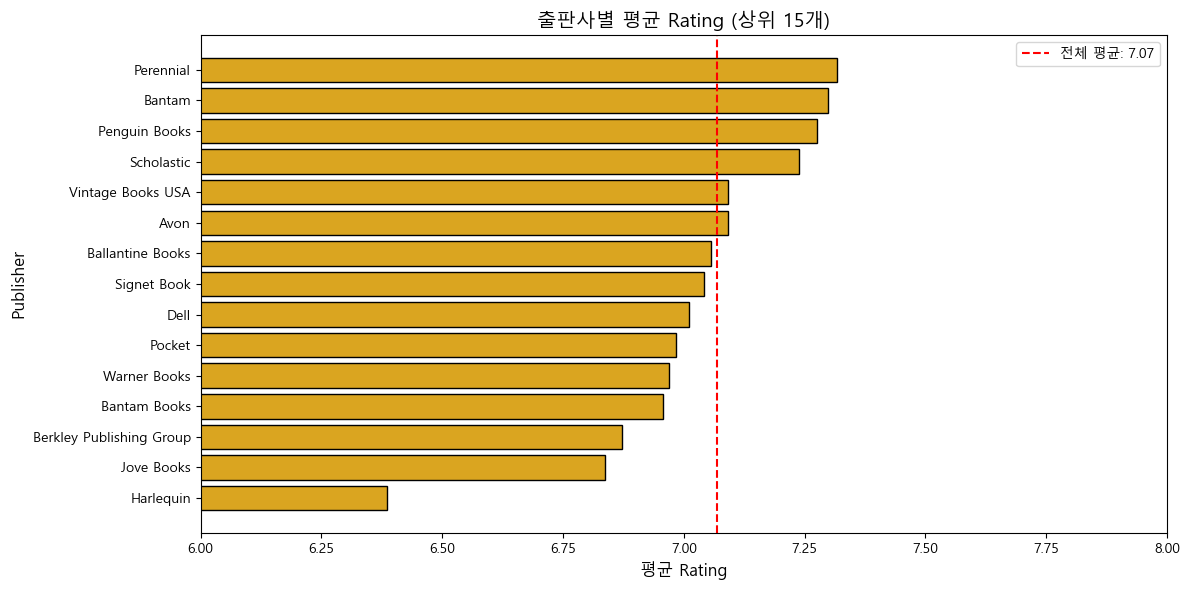

In [7]:
# 상위 15개 출판사별 Rating 분석
top_publishers = train_merged['publisher'].value_counts().head(15).index.tolist()
train_top_pubs = train_merged[train_merged['publisher'].isin(top_publishers)]

pub_rating = train_top_pubs.groupby('publisher').agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count')
).round(3).sort_values('rating_count', ascending=False)

print("[상위 15개 출판사별 Rating 통계]")
print(pub_rating)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

pub_sorted = pub_rating.sort_values('rating_mean', ascending=True)
ax.barh(pub_sorted.index, pub_sorted['rating_mean'], color='goldenrod', edgecolor='black')
ax.axvline(train['rating'].mean(), color='red', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax.set_xlabel('평균 Rating', fontsize=12)
ax.set_ylabel('Publisher', fontsize=12)
ax.set_title('출판사별 평균 Rating (상위 15개)', fontsize=14)
ax.legend()
ax.set_xlim(6, 8)

plt.tight_layout()
plt.show()

---
## 4.6 Rating vs Author (상위 작가)

[상위 20개 작가별 Rating 통계]
                           rating_mean  rating_std  rating_count
book_author                                                     
Stephen King                     7.268       2.454          3709
Nora Roberts                     7.030       2.450          2345
John Grisham                     6.987       2.282          2041
James Patterson                  7.218       2.300          1908
J. K. Rowling                    8.684       1.618          1397
Mary Higgins Clark               6.955       2.312          1348
Janet Evanovich                  7.475       2.165          1191
Dean R. Koontz                   6.941       2.393          1178
Anne Rice                        6.809       2.509          1001
Sue Grafton                      7.218       2.083           990
Tom Clancy                       6.726       2.404           980
Michael Crichton                 7.000       2.177           915
Nicholas Sparks                  7.156       2.592           904
JO

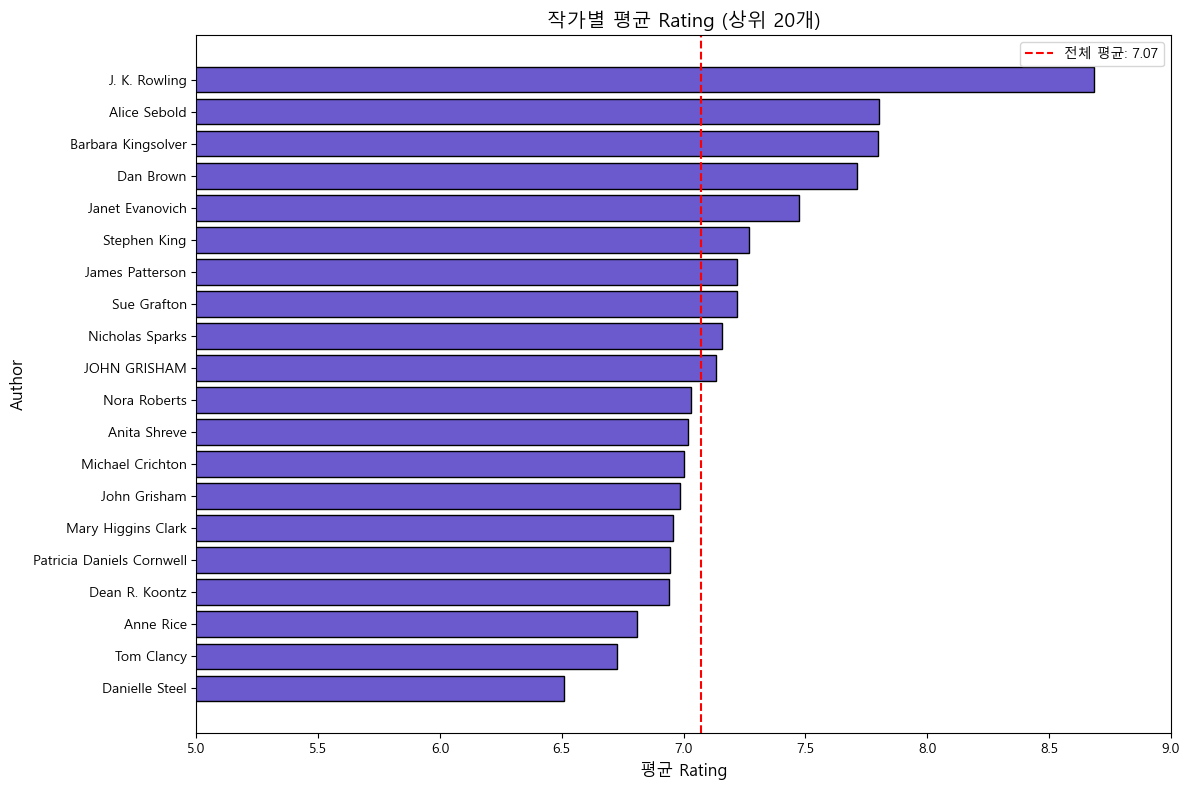

In [8]:
# 상위 20개 작가별 Rating 분석
top_authors = train_merged['book_author'].value_counts().head(20).index.tolist()
train_top_authors = train_merged[train_merged['book_author'].isin(top_authors)]

author_rating = train_top_authors.groupby('book_author').agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count')
).round(3).sort_values('rating_count', ascending=False)

print("[상위 20개 작가별 Rating 통계]")
print(author_rating)

# 시각화
fig, ax = plt.subplots(figsize=(12, 8))

author_sorted = author_rating.sort_values('rating_mean', ascending=True)
ax.barh(author_sorted.index, author_sorted['rating_mean'], color='slateblue', edgecolor='black')
ax.axvline(train['rating'].mean(), color='red', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax.set_xlabel('평균 Rating', fontsize=12)
ax.set_ylabel('Author', fontsize=12)
ax.set_title('작가별 평균 Rating (상위 20개)', fontsize=14)
ax.legend()
ax.set_xlim(5, 9)

plt.tight_layout()
plt.show()

---
## 4.7 User Activity vs Rating 경향

[User Activity 구간별 Rating 통계]
                     rating_mean  rating_std  rating_count  user_count
user_activity_group                                                   
1                          6.979       2.414         34617       34617
2                          6.815       2.447         15740        7870
3                          6.724       2.509         12279        4093
4-5                        6.750       2.492         18646        4237
6-10                       6.833       2.473         30826        4092
11-20                      6.925       2.520         35300        2421
21-50                      7.184       2.380         50557        1604
51-100                     7.279       2.310         39487         567
100+                       7.296       2.415         69343         302


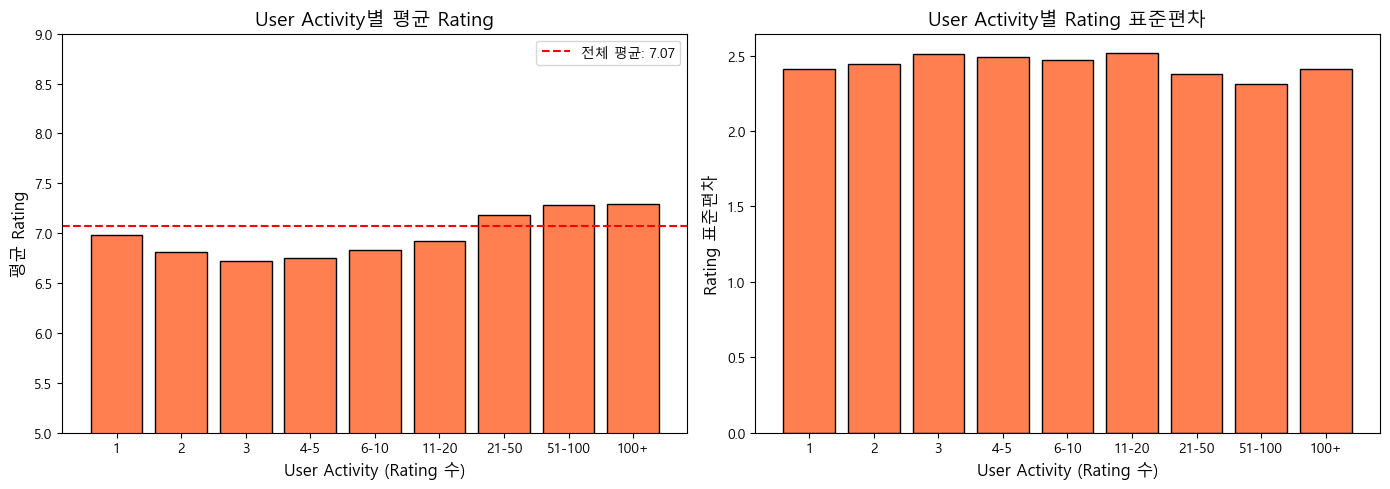

In [9]:
# User Activity 구간별 Rating 분석
activity_bins = [0, 1, 2, 3, 5, 10, 20, 50, 100, 10000]
activity_labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21-50', '51-100', '100+']
train_merged['user_activity_group'] = pd.cut(train_merged['user_rating_count'], 
                                              bins=activity_bins, labels=activity_labels, right=True)

activity_rating = train_merged.groupby('user_activity_group', observed=True).agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count'),
    user_count=('user_id', 'nunique')
).round(3)

print("[User Activity 구간별 Rating 통계]")
print(activity_rating)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 Rating
ax1 = axes[0]
ax1.bar(activity_rating.index.astype(str), activity_rating['rating_mean'], color='coral', edgecolor='black')
ax1.axhline(train['rating'].mean(), color='red', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax1.set_xlabel('User Activity (Rating 수)', fontsize=12)
ax1.set_ylabel('평균 Rating', fontsize=12)
ax1.set_title('User Activity별 평균 Rating', fontsize=14)
ax1.legend()
ax1.set_ylim(5, 9)

# Rating 표준편차
ax2 = axes[1]
ax2.bar(activity_rating.index.astype(str), activity_rating['rating_std'], color='coral', edgecolor='black')
ax2.set_xlabel('User Activity (Rating 수)', fontsize=12)
ax2.set_ylabel('Rating 표준편차', fontsize=12)
ax2.set_title('User Activity별 Rating 표준편차', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
# Heavy User 분석 (상위 1%)
heavy_user_threshold = user_stats['user_rating_count'].quantile(0.99)
heavy_users = user_stats[user_stats['user_rating_count'] >= heavy_user_threshold]['user_id']

train_heavy = train_merged[train_merged['user_id'].isin(heavy_users)]
train_normal = train_merged[~train_merged['user_id'].isin(heavy_users)]

print(f"\n[Heavy User 분석 (상위 1%, {len(heavy_users)}명)]")
print(f"Heavy User threshold: {heavy_user_threshold:.0f}개 이상 rating")
print(f"Heavy User Rating 수: {len(train_heavy):,}개 ({len(train_heavy)/len(train)*100:.1f}%)")
print(f"Heavy User 평균 Rating: {train_heavy['rating'].mean():.2f}")
print(f"Normal User 평균 Rating: {train_normal['rating'].mean():.2f}")
print(f"\nHeavy User Rating 분포:")
print(train_heavy['rating'].value_counts().sort_index())


[Heavy User 분석 (상위 1%, 601명)]
Heavy User threshold: 66개 이상 rating
Heavy User Rating 수: 93,467개 (30.5%)
Heavy User 평균 Rating: 7.30
Normal User 평균 Rating: 6.97

Heavy User Rating 분포:
rating
1      2663
2      4071
3      3420
4      4120
5      3322
6      6309
7     14395
8     22660
9     16986
10    15521
Name: count, dtype: int64


---
## 4.8 Item Popularity vs Rating 경향

[Item Popularity 구간별 Rating 통계]
                       rating_mean  rating_std  rating_count  item_count
item_popularity_group                                                   
1                            6.884       2.551         88392       88392
2                            6.959       2.476         38160       19080
3                            7.047       2.427         22641        7547
4-5                          7.085       2.397         28533        6594
6-10                         7.136       2.363         34030        4567
11-20                        7.209       2.333         31508        2196
21-50                        7.231       2.307         32358        1062
51-100                       7.347       2.287         16424         243
100+                         7.360       2.368         14749          96


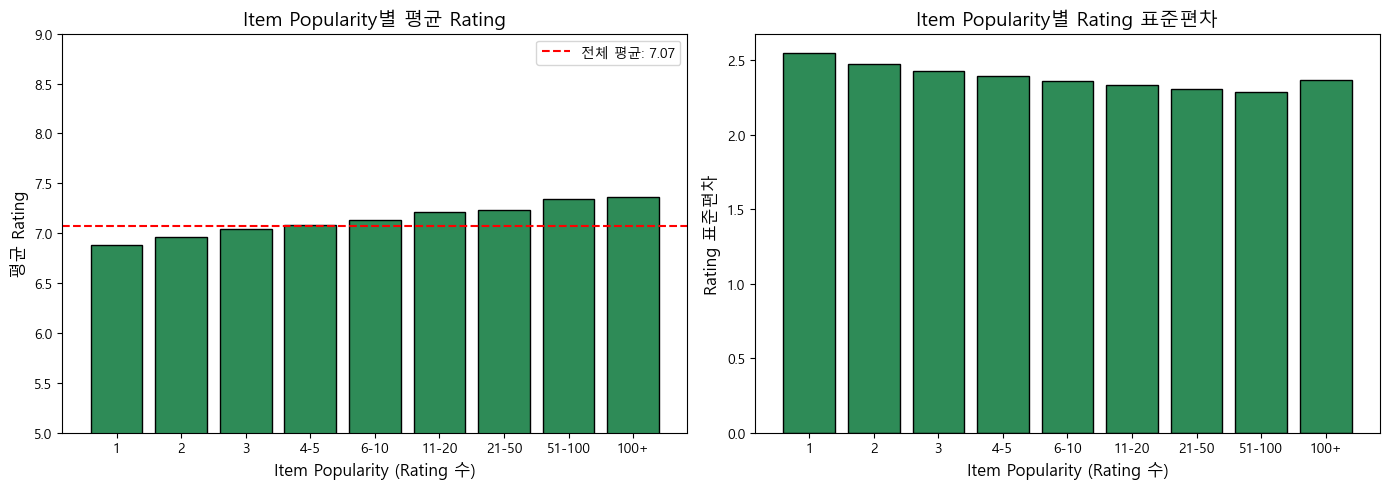

In [11]:
# Item Popularity 구간별 Rating 분석
pop_bins = [0, 1, 2, 3, 5, 10, 20, 50, 100, 10000]
pop_labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21-50', '51-100', '100+']
train_merged['item_popularity_group'] = pd.cut(train_merged['item_rating_count'], 
                                                bins=pop_bins, labels=pop_labels, right=True)

pop_rating = train_merged.groupby('item_popularity_group', observed=True).agg(
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count'),
    item_count=('isbn', 'nunique')
).round(3)

print("[Item Popularity 구간별 Rating 통계]")
print(pop_rating)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 Rating
ax1 = axes[0]
ax1.bar(pop_rating.index.astype(str), pop_rating['rating_mean'], color='seagreen', edgecolor='black')
ax1.axhline(train['rating'].mean(), color='red', linestyle='--', label=f'전체 평균: {train["rating"].mean():.2f}')
ax1.set_xlabel('Item Popularity (Rating 수)', fontsize=12)
ax1.set_ylabel('평균 Rating', fontsize=12)
ax1.set_title('Item Popularity별 평균 Rating', fontsize=14)
ax1.legend()
ax1.set_ylim(5, 9)

# Rating 표준편차
ax2 = axes[1]
ax2.bar(pop_rating.index.astype(str), pop_rating['rating_std'], color='seagreen', edgecolor='black')
ax2.set_xlabel('Item Popularity (Rating 수)', fontsize=12)
ax2.set_ylabel('Rating 표준편차', fontsize=12)
ax2.set_title('Item Popularity별 Rating 표준편차', fontsize=14)

plt.tight_layout()
plt.show()

---
## 4.9 User 평균 Rating vs Rating 표준편차

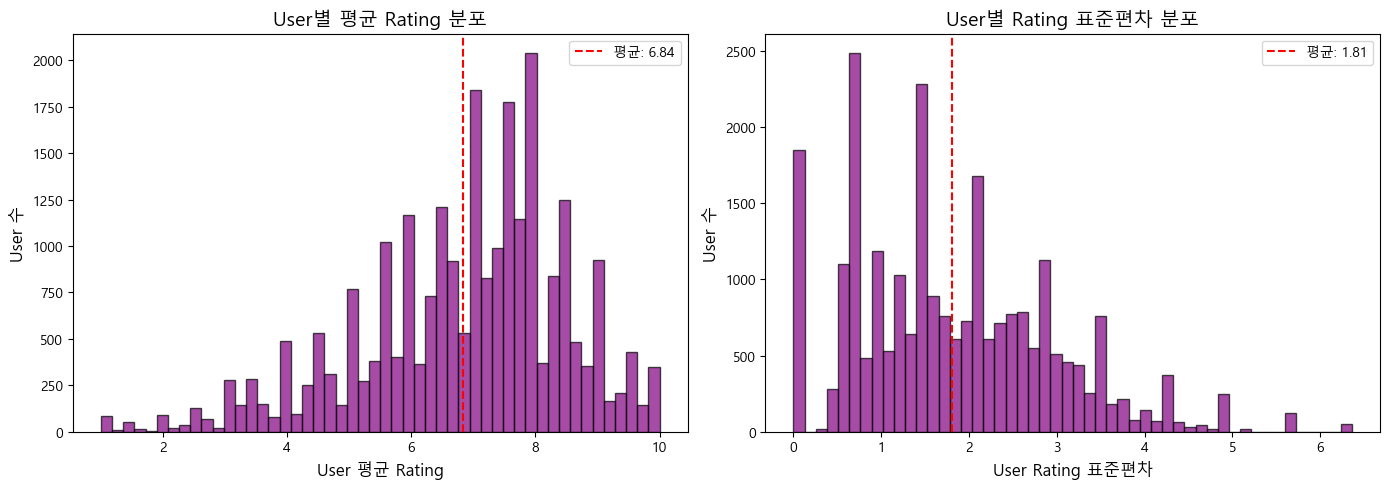


[User별 Rating 통계 요약 (2개 이상 rating한 user)]
User 수: 25,186
평균 Rating의 평균: 6.84
평균 Rating의 표준편차: 1.67
Rating 표준편차의 평균: 1.81


In [12]:
# 2개 이상 rating한 user만 분석 (std 계산 가능)
user_stats_filtered = user_stats[user_stats['user_rating_count'] >= 2].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User 평균 Rating 분포
ax1 = axes[0]
ax1.hist(user_stats_filtered['user_rating_mean'], bins=50, color='purple', edgecolor='black', alpha=0.7)
ax1.axvline(user_stats_filtered['user_rating_mean'].mean(), color='red', linestyle='--', 
            label=f'평균: {user_stats_filtered["user_rating_mean"].mean():.2f}')
ax1.set_xlabel('User 평균 Rating', fontsize=12)
ax1.set_ylabel('User 수', fontsize=12)
ax1.set_title('User별 평균 Rating 분포', fontsize=14)
ax1.legend()

# User Rating 표준편차 분포
ax2 = axes[1]
ax2.hist(user_stats_filtered['user_rating_std'].dropna(), bins=50, color='purple', edgecolor='black', alpha=0.7)
ax2.axvline(user_stats_filtered['user_rating_std'].mean(), color='red', linestyle='--', 
            label=f'평균: {user_stats_filtered["user_rating_std"].mean():.2f}')
ax2.set_xlabel('User Rating 표준편차', fontsize=12)
ax2.set_ylabel('User 수', fontsize=12)
ax2.set_title('User별 Rating 표준편차 분포', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n[User별 Rating 통계 요약 (2개 이상 rating한 user)]")
print(f"User 수: {len(user_stats_filtered):,}")
print(f"평균 Rating의 평균: {user_stats_filtered['user_rating_mean'].mean():.2f}")
print(f"평균 Rating의 표준편차: {user_stats_filtered['user_rating_mean'].std():.2f}")
print(f"Rating 표준편차의 평균: {user_stats_filtered['user_rating_std'].mean():.2f}")

---
## 4.10 Item 평균 Rating vs Item Popularity

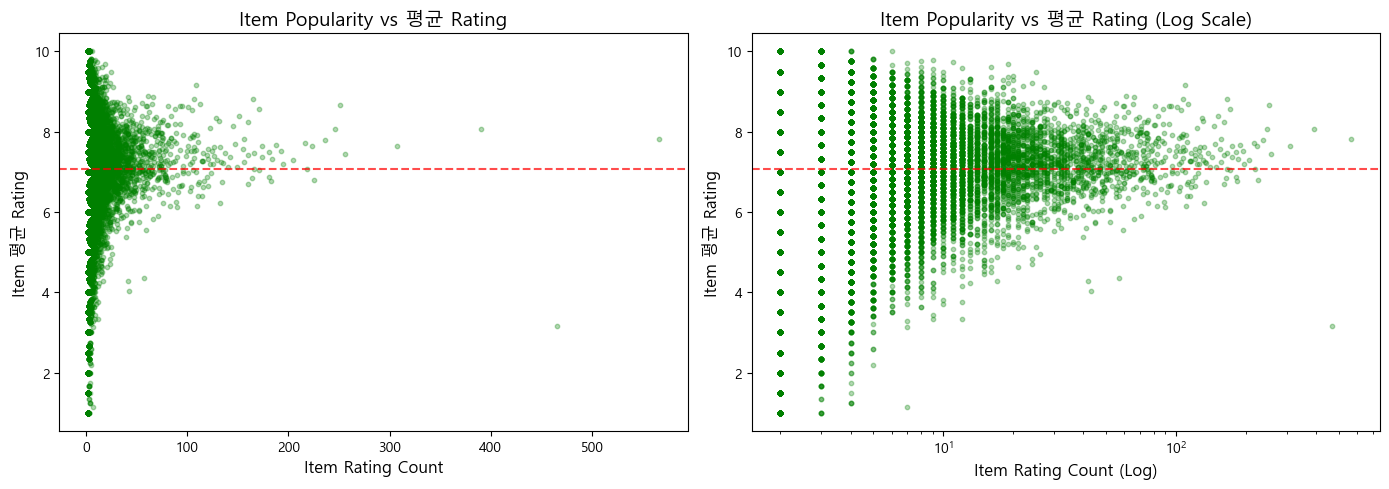


Item Popularity와 평균 Rating의 상관계수: 0.0337


In [13]:
# Scatter plot: Item Popularity vs 평균 Rating
item_stats_filtered = item_stats[item_stats['item_rating_count'] >= 2].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 일반 스케일
ax1 = axes[0]
ax1.scatter(item_stats_filtered['item_rating_count'], item_stats_filtered['item_rating_mean'], 
            alpha=0.3, s=10, color='green')
ax1.axhline(train['rating'].mean(), color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Item Rating Count', fontsize=12)
ax1.set_ylabel('Item 평균 Rating', fontsize=12)
ax1.set_title('Item Popularity vs 평균 Rating', fontsize=14)

# Log 스케일
ax2 = axes[1]
ax2.scatter(item_stats_filtered['item_rating_count'], item_stats_filtered['item_rating_mean'], 
            alpha=0.3, s=10, color='green')
ax2.axhline(train['rating'].mean(), color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Item Rating Count (Log)', fontsize=12)
ax2.set_ylabel('Item 평균 Rating', fontsize=12)
ax2.set_title('Item Popularity vs 평균 Rating (Log Scale)', fontsize=14)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

# 상관관계
corr = item_stats_filtered['item_rating_count'].corr(item_stats_filtered['item_rating_mean'])
print(f"\nItem Popularity와 평균 Rating의 상관계수: {corr:.4f}")

---
## 4.11 Train vs Test 분포 비교

In [14]:
# Test 데이터에 메타데이터 병합
test_merged = test.merge(users, on='user_id', how='left')
test_merged = test_merged.merge(books, on='isbn', how='left')
test_merged = test_merged.merge(user_stats, on='user_id', how='left')
test_merged = test_merged.merge(item_stats, on='isbn', how='left')

print("[Train vs Test 기본 비교]")
print(f"\nTrain 크기: {len(train):,}")
print(f"Test 크기: {len(test):,}")

[Train vs Test 기본 비교]

Train 크기: 306,795
Test 크기: 76,699


In [15]:
# User Activity 분포 비교 (Train에서의 activity 기준)
print("\n[Test User의 Train Activity 분포]")

# Test user 중 Train에 있는 user의 activity
test_user_activity = test_merged['user_rating_count'].fillna(0)  # Cold user는 0

print(f"Cold User (Train에 없음): {test_user_activity.isna().sum() + (test_user_activity == 0).sum():,}개 interaction")
print(f"\nTest User Activity 통계 (Train 기준):")
print(test_user_activity[test_user_activity > 0].describe())

# 구간별 비교
test_merged['user_activity_group'] = pd.cut(test_merged['user_rating_count'].fillna(0), 
                                             bins=[-1, 0, 1, 2, 5, 10, 50, 10000], 
                                             labels=['Cold', '1', '2', '3-5', '6-10', '11-50', '50+'])

test_activity_dist = test_merged['user_activity_group'].value_counts().sort_index()
print(f"\nTest의 User Activity 구간별 분포:")
print(test_activity_dist)


[Test User의 Train Activity 분포]
Cold User (Train에 없음): 8,677개 interaction

Test User Activity 통계 (Train 기준):
count    68022.000000
mean       284.199450
std        974.478655
min          1.000000
25%          8.000000
50%         31.000000
75%        102.000000
max       5520.000000
Name: user_rating_count, dtype: float64

Test의 User Activity 구간별 분포:
user_activity_group
Cold      8677
1         3860
2         3070
3-5       6513
6-10      6844
11-50    20777
50+      26958
Name: count, dtype: int64


In [16]:
# Item Popularity 분포 비교
print("\n[Test Item의 Train Popularity 분포]")

test_item_pop = test_merged['item_rating_count'].fillna(0)

print(f"Cold Item (Train에 없음): {(test_item_pop == 0).sum():,}개 interaction")
print(f"\nTest Item Popularity 통계 (Train 기준):")
print(test_item_pop[test_item_pop > 0].describe())

# 구간별 비교
test_merged['item_popularity_group'] = pd.cut(test_merged['item_rating_count'].fillna(0), 
                                               bins=[-1, 0, 1, 2, 5, 10, 50, 10000], 
                                               labels=['Cold', '1', '2', '3-5', '6-10', '11-50', '50+'])

test_pop_dist = test_merged['item_popularity_group'].value_counts().sort_index()
print(f"\nTest의 Item Popularity 구간별 분포:")
print(test_pop_dist)


[Test Item의 Train Popularity 분포]
Cold Item (Train에 없음): 19,793개 interaction

Test Item Popularity 통계 (Train 기준):
count    56906.000000
mean        26.025656
std         54.264731
min          1.000000
25%          2.000000
50%          7.000000
75%         24.000000
max        566.000000
Name: item_rating_count, dtype: float64

Test의 Item Popularity 구간별 분포:
item_popularity_group
Cold     19793
1         9006
2         5488
3-5      10511
6-10      8198
11-50    15928
50+       7775
Name: count, dtype: int64


In [17]:
# Cold Start 상세 분석
print("\n" + "="*60)
print("Cold Start 상세 분석")
print("="*60)

# User Cold Start
test_users = set(test['user_id'].unique())
train_users = set(train['user_id'].unique())
cold_users = test_users - train_users

cold_user_interactions = test[test['user_id'].isin(cold_users)]
print(f"\n[User Cold Start]")
print(f"Cold User 수: {len(cold_users):,}명")
print(f"Cold User의 Test interaction 수: {len(cold_user_interactions):,}개 ({len(cold_user_interactions)/len(test)*100:.1f}%)")

# Item Cold Start
test_items = set(test['isbn'].unique())
train_items = set(train['isbn'].unique())
cold_items = test_items - train_items

cold_item_interactions = test[test['isbn'].isin(cold_items)]
print(f"\n[Item Cold Start]")
print(f"Cold Item 수: {len(cold_items):,}개")
print(f"Cold Item의 Test interaction 수: {len(cold_item_interactions):,}개 ({len(cold_item_interactions)/len(test)*100:.1f}%)")

# 둘 다 Cold인 경우
both_cold = test[(test['user_id'].isin(cold_users)) & (test['isbn'].isin(cold_items))]
print(f"\n[User & Item 둘 다 Cold]")
print(f"해당 interaction 수: {len(both_cold):,}개 ({len(both_cold)/len(test)*100:.1f}%)")


Cold Start 상세 분석

[User Cold Start]
Cold User 수: 8,266명
Cold User의 Test interaction 수: 8,677개 (11.3%)

[Item Cold Start]
Cold Item 수: 19,793개
Cold Item의 Test interaction 수: 19,793개 (25.8%)

[User & Item 둘 다 Cold]
해당 interaction 수: 1,734개 (2.3%)


---
## Step 4 요약

**결과를 복사해서 공유해주세요!**

핵심 확인 사항:
1. 어떤 User/Item 특성이 Rating과 연관이 있는가?
2. User Activity/Item Popularity에 따른 Rating 경향
3. Heavy User의 영향력
4. Cold Start 문제의 심각성